# Analysis of run739HF data

A quick exploratory analysis of run739HF dataset obtained from Victor. 
Dataset is provided by Karl.

## Import modules and define functions

In [7]:
%matplotlib inline
import scipy
import pynbody as pb
from scipy import stats as st
from matplotlib.colors import LogNorm
from matplotlib.pylab import *

def pbload(filename, paramname=None):
    print('Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    print('Done!')
    return sim

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def plot_image ():
    image = plt.imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    xcent = (xedges[1:] + xedges[:-1]) / 2
    ycent = (yedges[1:] + yedges[:-1]) / 2

    plt.title(plt_title)  
    cbar = plt.colorbar()
    cbar.set_label(cbar_label)
    axes = plt.gca()
    axes.set_aspect(1)
    # axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
    axes.set_xlabel('x [kpc]')
    axes.set_ylabel('y [kpc]')
    axes.set_xlim(-xlim, xlim)
    axes.set_ylim(-ylim, ylim)
    plt.show()

base_dir = '/home/ubuntu/projects/S2B/shared/'
data_fname = base_dir + 'run739HF/run739HF.02000'
param_fname = base_dir + 'run739HF/run739HF.param'

## Load data

Loading a simulation output using the `pynbody.load()` function, which tries to automatically determine which type of code output you have:

In [8]:
s = pbload(data_fname,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.02000 ...
Done!


Note that the above assumes you have downloaded and unpacked the test data in the above folder.

## Data exploration

In [89]:
s

<SimSnap "/home/ubuntu/projects/S2B/shared/run739HF/run739HF.00500" len=13334419>

In [111]:
len(s)

11351979

`stars`, `gas`, `dark` also available as `s`, `g`, `d`

In [112]:
len(s.star), len(s.gas), len(s.dark)

(1708826, 4643153, 5000000)

The `properties` attribute of a `SimSnap` tells us some more basic info 

In [113]:
s.properties

{'time': Unit("9.99e-01 s kpc km**-1")}

In [9]:
s.properties['time'].in_units('Gyr')

9.76641980829801

Which quantities do we have available?

In [95]:
s.keys()

['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi']

None! Because pynbody "lazy-loads" data... so lets see which data is actually on-disk:

In [96]:
s.loadable_keys()

['pos', 'eps', 'mass', 'vel', 'phi']

vel - velocity components vx, vy, vz - **km/s ?**, 
**phi - ?**, 
**eps - ?**, 
pos - position components x, y, z - kpc, 
mass - particle mass, **units?**

By default everything is in system units, but most of the time thinking in physical units is easier: But aparently there is no physical units defined in this dataset.

In [5]:
s.physical_units()

To access any of these arrays or vectors, you access them like a python dictionary: 

In [98]:
s.star['pos']

SimArray([[-1.613484  ,  1.86947438,  0.17605481],
          [-0.39546469,  2.91097387,  0.0772424 ],
          [ 0.20063227,  0.16928241,  0.01192014],
          ...,
          [ 3.23663152,  4.40004231,  0.3041144 ],
          [ 3.30373781,  3.3540619 ,  0.44918194],
          [ 3.76980885,  3.29152095,  0.67310031]], 'kpc')

Note that each array has units attached...

In [99]:
s.star['vel']

SimArray([[-176.26639483,   94.48406955, -101.91103511],
          [-201.3503708 ,   44.35959813,  -28.01706852],
          [-168.96811808,  -50.77138481,  148.33743965],
          ...,
          [-231.92143258,   70.43482126,  -43.20717834],
          [-132.18281491,  127.89441667,  -29.50506165],
          [-176.17350389,  112.9754353 ,    2.13486788]], 'km s**-1')

We have defined many useful quantities that are automatically calculated for you. For example, the radial and tangential velocities are simply obtained by

In [100]:
s.star['vt'],s.star['vr']

(SimArray([135.46434645, 195.83824789, 170.6198125 , ..., 231.80286053,
           186.2260413 , 201.21556551], 'km s**-1'),
 SimArray([ 178.97583989,   70.29994707, -154.98656079, ...,  -82.96329939,
             -4.43718108,  -57.59692968], 'km s**-1'))

We can try to access individual position and velocity components.

In [101]:
s.star['x'],s.star['y'],s.star['z']

(SimArray([-1.613484  , -0.39546469,  0.20063227, ...,  3.23663152,
            3.30373781,  3.76980885], 'kpc'),
 SimArray([1.86947438, 2.91097387, 0.16928241, ..., 4.40004231, 3.3540619 ,
           3.29152095], 'kpc'),
 SimArray([0.17605481, 0.0772424 , 0.01192014, ..., 0.3041144 , 0.44918194,
           0.67310031], 'kpc'))

In [102]:
s.star['vx'],s.star['vy'],s.star['vz']

(SimArray([-176.26639483, -201.3503708 , -168.96811808, ..., -231.92143258,
           -132.18281491, -176.17350389], 'km s**-1'),
 SimArray([ 94.48406955,  44.35959813, -50.77138481, ...,  70.43482126,
           127.89441667, 112.9754353 ], 'km s**-1'),
 SimArray([-101.91103511,  -28.01706852,  148.33743965, ...,  -43.20717834,
            -29.50506165,    2.13486788], 'km s**-1'))

## Working with density profiles

Text(0, 0.5, '$\\rho_{DM}$ [M$_{\\odot}$ kpc$^{-3}$]')

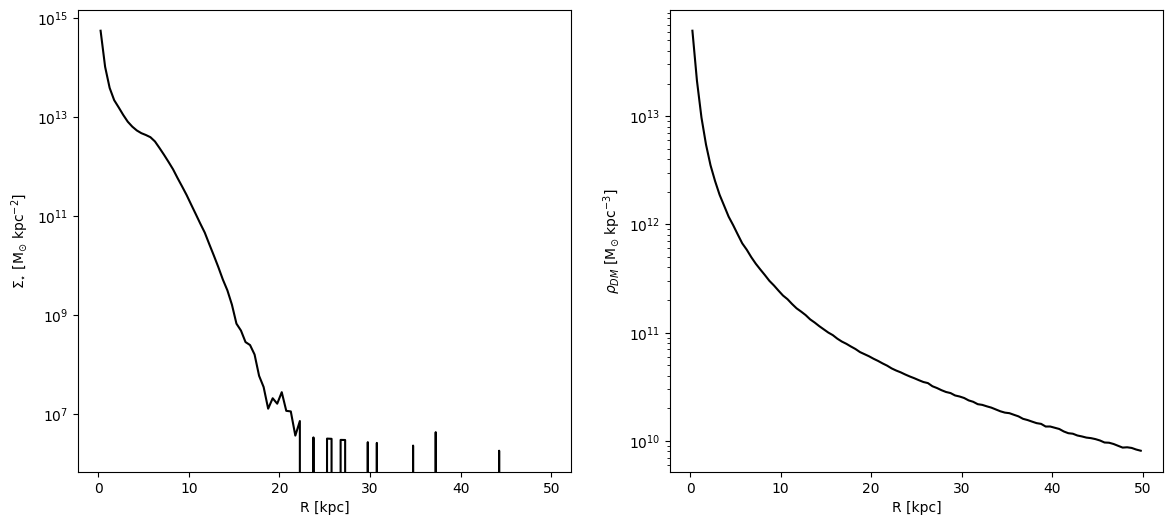

In [24]:
# center on the largest halo and align the disk
pb.analysis.angmom.faceon(s)

# convert all units to something reasonable (kpc, Msol etc)
s.physical_units()

# create a profile object for the stars (by default this is a 2D profile)
p = pb.analysis.profile.Profile(s.star, vmin =.01, max=50)

# Checking derivable keys
p.derivable_keys()

# make the figure and sub plots
f, axs = plt.subplots(1,2,figsize=(14,6))

# make the plot
axs[0].plot(p['rbins'],p['density'], 'k')
axs[0].semilogy()
axs[0].set_xlabel('R [kpc]')
axs[0].set_ylabel(r'$\Sigma_{\star}$ [M$_{\odot}$ kpc$^{-2}$]')

# make a 3D density plot of the dark matter (note ndim=3 in the constructor below)
p = pb.analysis.profile.Profile(s.dark,min=.01,max=50,ndim=3)

axs[1].plot(p['rbins'],p['density'], 'k')
axs[1].semilogy()
axs[1].set_xlabel('R [kpc]')
axs[1].set_ylabel(r'$\rho_{DM}$ [M$_{\odot}$ kpc$^{-3}$]')

## Rendering simple images with pynbody built-in functions

We render some simple images with pynbody image function, faceon, edgeon.

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00200 ...
Done!


SimArray([[0.29355705, 0.2963762 , 0.29919532, ..., 0.5039834 ,
           0.4880684 , 0.4721534 ],
          [0.28345546, 0.2870212 , 0.29058692, ..., 0.5251023 ,
           0.50870365, 0.49230495],
          [0.27335384, 0.27766618, 0.28197855, ..., 0.54622126,
           0.52933884, 0.51245654],
          ...,
          [1.1041652 , 1.1644086 , 1.2246519 , ..., 1.0085338 ,
           0.97823375, 0.94793373],
          [1.066912  , 1.118449  , 1.1699859 , ..., 0.9639388 ,
           0.935772  , 0.90760535],
          [1.0296588 , 1.0724893 , 1.1153197 , ..., 0.91934365,
           0.89331025, 0.8672769 ]], dtype=float32, '2.33e+05 Msol kpc**-3')

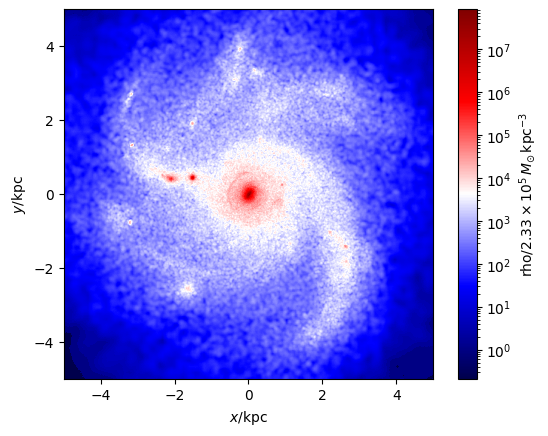

In [125]:
import pynbody.plot.sph as sph
cmap = 'seismic'

s = pbload(data_fname,param_fname)
pb.analysis.angmom.faceon(s)
sph.image(s.star,qty="rho",width=10,cmap=cmap)

Rotate 70 degrees clockwise about Z axis.

SimArray([[0.7417013 , 0.7681598 , 0.7946181 , ..., 1.9675367 ,
           2.0267909 , 2.0860453 ],
          [0.7280967 , 0.75246453, 0.7768322 , ..., 1.9637189 ,
           2.025992  , 2.0882652 ],
          [0.71449214, 0.73676926, 0.75904644, ..., 1.9599009 ,
           2.025193  , 2.0904849 ],
          ...,
          [0.30664632, 0.32316402, 0.33968168, ..., 0.40743554,
           0.40772393, 0.4080123 ],
          [0.28240484, 0.2973231 , 0.31224138, ..., 0.40727177,
           0.40769202, 0.4081122 ],
          [0.25816345, 0.27148226, 0.28480107, ..., 0.40710804,
           0.40766007, 0.4082121 ]], dtype=float32, '2.33e+05 Msol kpc**-3')

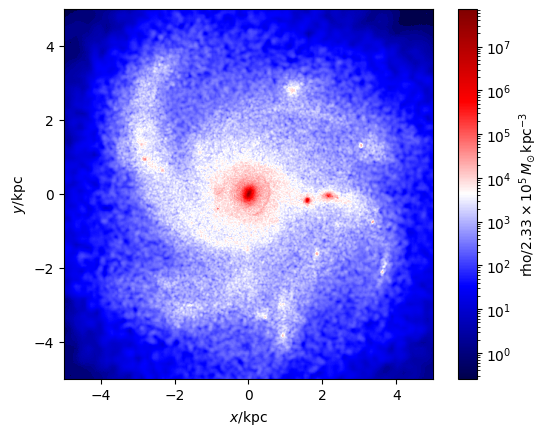

In [126]:
s.rotate_z(-170)
sph.image(s.star,qty="rho",width=10,cmap=cmap)

Let us rotate 90 clockwise about X axis to get an edge-on view.

SimArray([[0.16528651, 0.16091229, 0.1565381 , ..., 0.2287083 ,
           0.22113608, 0.21356386],
          [0.16560663, 0.16121861, 0.15683055, ..., 0.24095961,
           0.23266667, 0.22437373],
          [0.16592678, 0.1615249 , 0.15712301, ..., 0.25321093,
           0.24419726, 0.2351836 ],
          ...,
          [0.18421993, 0.18697317, 0.18972641, ..., 0.10268491,
           0.10312499, 0.10356507],
          [0.18212204, 0.18492039, 0.18771873, ..., 0.10270346,
           0.10314707, 0.10359067],
          [0.18002416, 0.1828676 , 0.18571103, ..., 0.10272202,
           0.10316915, 0.10361628]], dtype=float32, '2.33e+05 Msol kpc**-3')

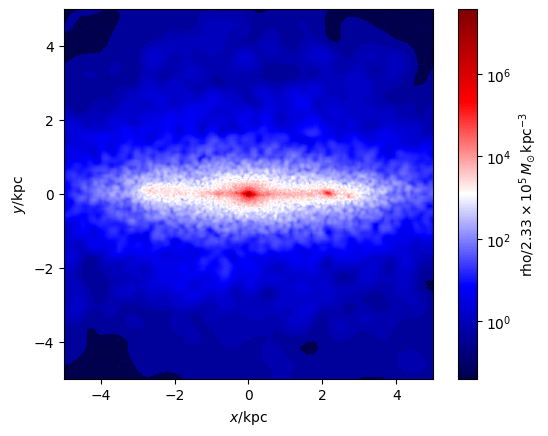

In [127]:
s.rotate_x(-90)
sph.image(s.star,qty="rho",width=10,cmap=cmap)

## Bar angle 0 - binned 2d-statistics for number density and velocity

### Number density

#### Load data

In [130]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00200 ...
Done!


In [10]:
# Define global variables

bins = 50
xlim, ylim = 25, 25
cmap = 'seismic'

#### Face-on number density

Rotate to 170 or 10 degrees clockwise about Z axis to allign the bar.
Calculate the binned 2d statisticss for number densities and plot face-on view.
Plot the grid to visually confirm the bar alignment.

In [34]:
s.rotate_z(-170) # 01000 dataset
# s.rotate_z(-10) # 00500 dataset

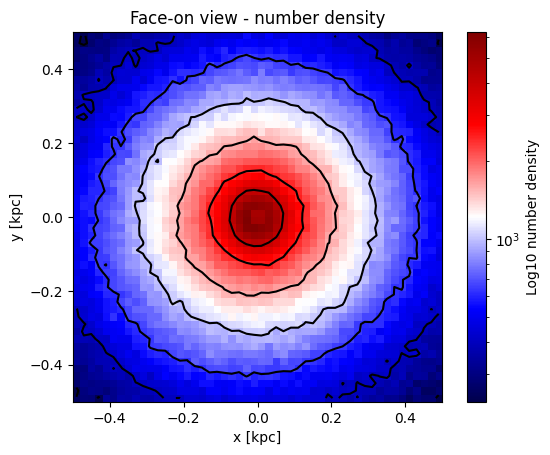

In [13]:
# Zoom in
xlim, ylim = 0.5, 0.5
plt_title = 'Face-on view - number density'
cbar_label = 'Log10 number density'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
# axes.grid(color='w', linestyle='-', linewidth=1)

plt.show()


#### Inclination 60 deg - number density

Rotate 60 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [39]:
s.rotate_x(-60)

/tmp/ipykernel_2069/2856188639.py:25: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


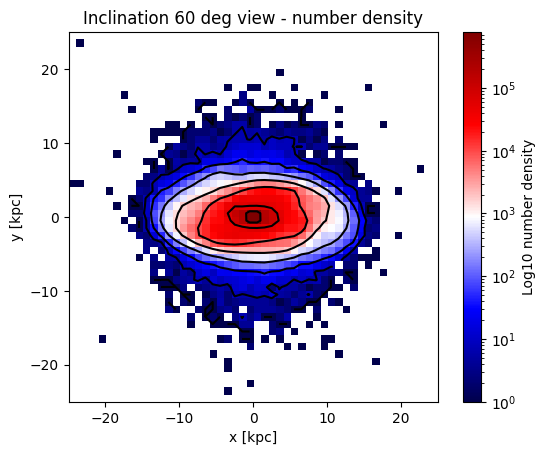

In [40]:
# Zoom in
# xlim, ylim = 8, 8
plt_title = 'Inclination 60 deg view - number density'
cbar_label = 'Log10 number density'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Edge-on - number density

Rotate 60 + 30 = 90 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [33]:
s.rotate_x(-30)

/tmp/ipykernel_1554/3520867781.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


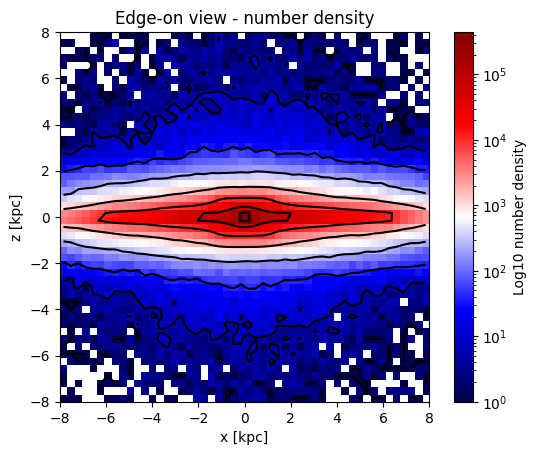

In [35]:
# Zoom in
xlim, ylim = 8, 8
plt_title = 'Edge-on view - number density'
cbar_label = 'Log10 number density'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()

### Velocity distribution

#### Load data

In [36]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname2,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01000 ...
Done!


#### Basic velocity distribution histograms

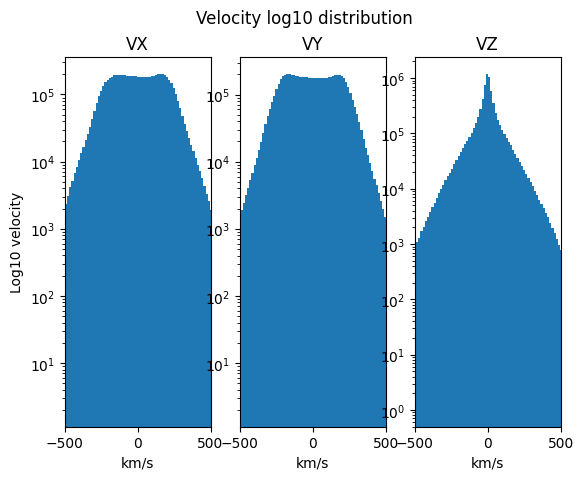

In [37]:
# Extracting position and velocity components

x = s.star['pos'][:,0]
y = s.star['pos'][:,1]
z = s.star['pos'][:,2]
vx = s.star['vel'][:,0]
vy = s.star['vel'][:,1]
vz = s.star['vel'][:,2]

x_lim = 500
bins = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Velocity log10 distribution')
ax1.hist(vx, log = True, bins = bins)
ax1.set_title('VX')
ax1.set_xlim(-x_lim, x_lim)
ax1.set_xlabel('km/s')
ax1.set_ylabel('Log10 velocity')
ax2.hist(vy, log = True, bins = bins)
ax2.set_title('VY')
ax2.set_xlim(-x_lim, x_lim)
ax2.set_xlabel('km/s')
ax3.hist(vz, log = True, bins = bins)
ax3.set_title('VZ')
ax3.set_xlim(-x_lim, x_lim)
ax3.set_xlabel('km/s')
plt.show()

#### Face-on - mean velocity

In [38]:
s.rotate_z(-170)
# s.rotate_z(-10)

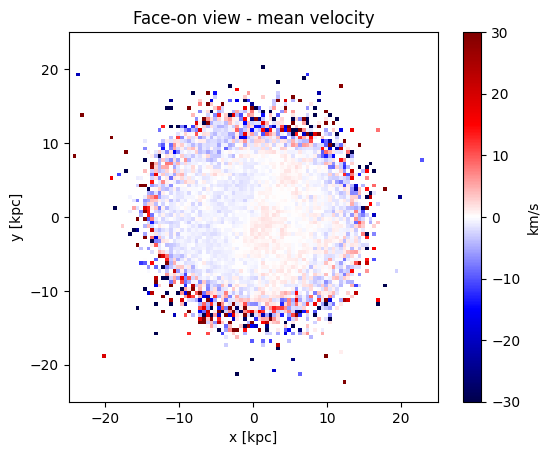

In [41]:
# Zoom out
xlim, ylim = 25, 25
plt_title = 'Face-on view - mean velocity'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Face-on - velocity dispersion

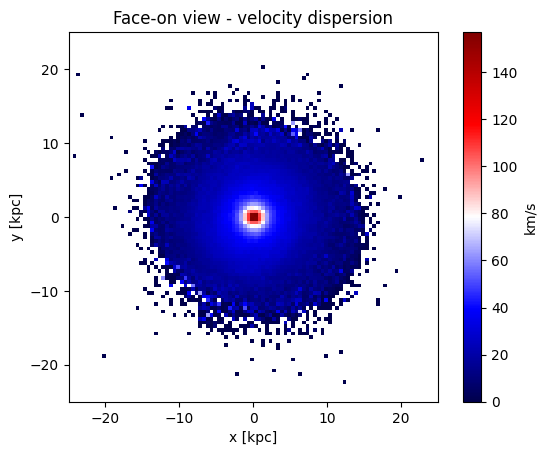

In [42]:
plt_title = 'Face-on view - velocity dispersion'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Inclination 60 deg - mean velocity

In [43]:
s.rotate_x(-60)

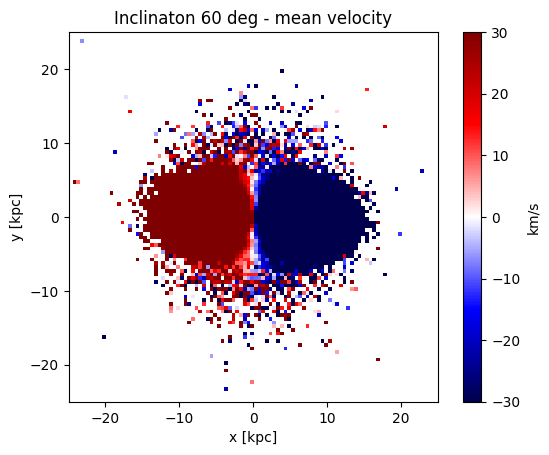

In [44]:
# Zoom out
xlim, ylim = 25, 25
plt_title = 'Inclinaton 60 deg - mean velocity'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Inclination 60 deg - velocity dispersion

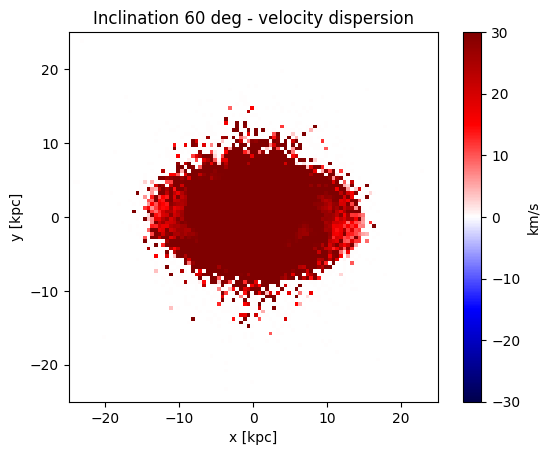

In [45]:
# Zoom out
xlim, ylim = 25, 25
plt_title = 'Inclination 60 deg - velocity dispersion'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Edge-on - mean velocity

Rotate 90 degrees clockwise about X axis for edge-on view.
Calculate the binned velocity 2d statistics and plot.

In [46]:
s.rotate_x(-30)

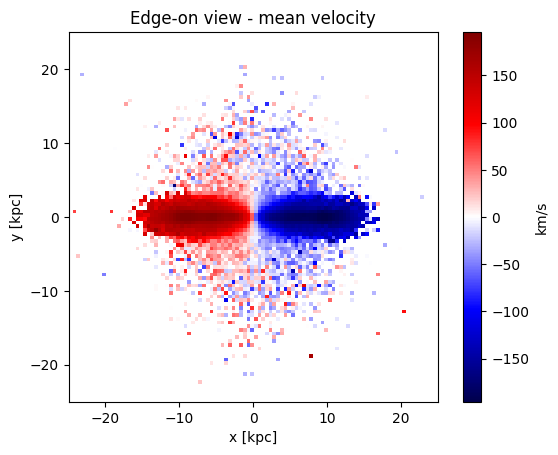

In [47]:
plt_title = 'Edge-on view - mean velocity'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - velocity dispersion

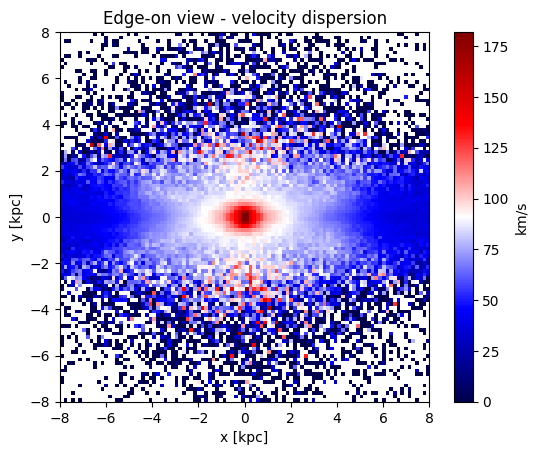

In [48]:
# Zoom in
xlim, ylim = 8, 8
plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - h3

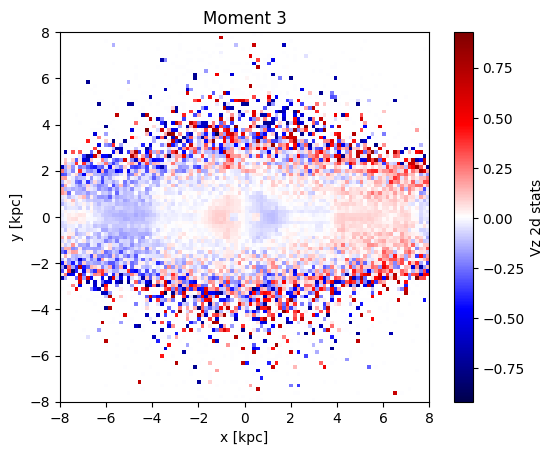

In [49]:
# Zoom in
xlim, ylim = 8, 8
m = 3
plt_title = 'Gauss-Hermite Moment 3'
cbar_label = 'Vz h3 stats'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
# axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Edge-on - h4

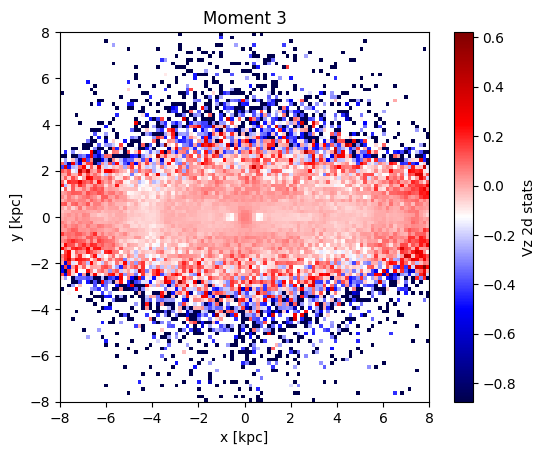

In [50]:
# Zoom in
xlim, ylim = 8, 8
m = 4
plt_title = 'Gauss-Hermite Moment 4'
cbar_label = 'Vz h4 stats'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
# axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

## Bar angle 45 - binned 2d-statistics for number density and velocity

### Number density

#### Load data

In [51]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname2,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01000 ...
Done!


/home/ubuntu/.local/lib/python3.10/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


In [52]:
# Define global variables.

bins = 50
xlim, ylim = 25, 25
cmap = 'seismic'

#### Face-on number density

Rotate to 25 degree clockwise about Z axis to bar have the bar angle 45.
Calculate the binned 2d statisticss for number densities and plot face-on view.
Plot the grid to visually confirm the bar alignment.

In [53]:
s.rotate_z(-125)

/tmp/ipykernel_1554/137883193.py:23: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


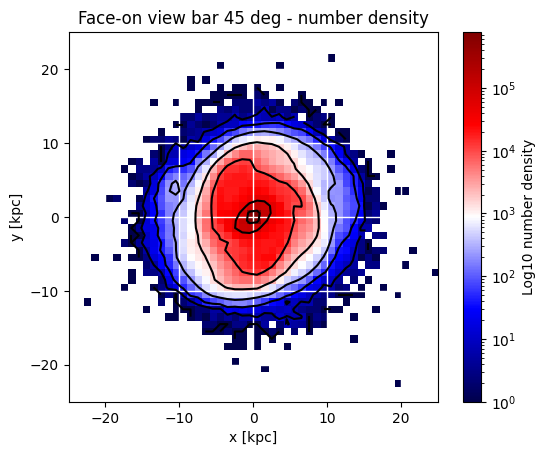

In [54]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Face-on view bar 45 deg - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
axes.grid(color='w', linestyle='-', linewidth=1)

'''
#calculate equation for trendline
zz = np.polyfit(s.star['x'], s.star['y'], 1)
pp = np.poly1d(zz)

#add trendline to plot
plt.plot(s.star['x'], pp(s.star['x']),color="w", linewidth=1, linestyle="-")
'''
plt.show()


#### Inclination 60 deg - number density

Rotate 60 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [55]:
s.rotate_x(-60)

/tmp/ipykernel_1554/3741675562.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


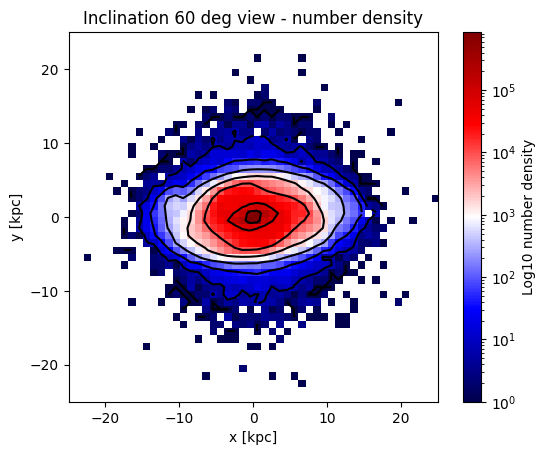

In [56]:
# Zoom in
# xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Inclination 60 deg view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - number density

Rotate 60 + 30 = 90 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [57]:
s.rotate_x(-30)

/tmp/ipykernel_1554/494305014.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


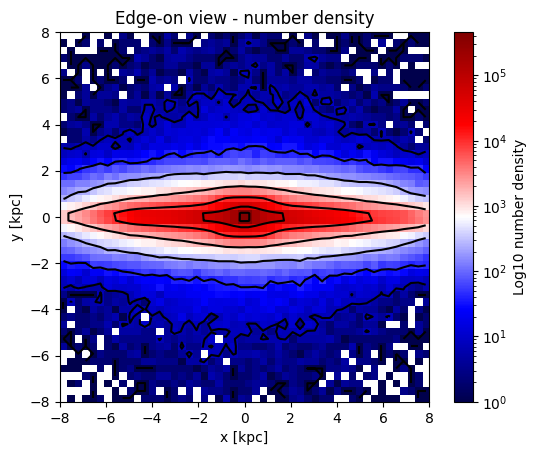

In [58]:
# Zoom in
xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Edge-on view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('x [kpc]')
axes.set_ylabel('y [kpc]')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


### Velocity distribution

#### Load data

In [59]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname2,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.01000 ...
Done!


/home/ubuntu/.local/lib/python3.10/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


#### Basic velocity distribution histograms

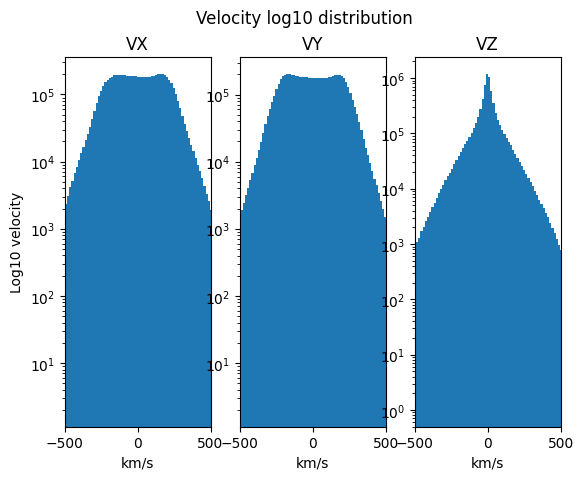

In [60]:
# Extracting position and velocity components

x = s.star['pos'][:,0]
y = s.star['pos'][:,1]
z = s.star['pos'][:,2]
vx = s.star['vel'][:,0]
vy = s.star['vel'][:,1]
vz = s.star['vel'][:,2]

x_lim = 500
bins = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Velocity log10 distribution')
ax1.hist(vx, log = True, bins = bins)
ax1.set_title('VX')
ax1.set_xlim(-x_lim, x_lim)
ax1.set_xlabel('km/s')
ax1.set_ylabel('Log10 velocity')
ax2.hist(vy, log = True, bins = bins)
ax2.set_title('VY')
ax2.set_xlim(-x_lim, x_lim)
ax2.set_xlabel('km/s')
ax3.hist(vz, log = True, bins = bins)
ax3.set_title('VZ')
ax3.set_xlim(-x_lim, x_lim)
ax3.set_xlabel('km/s')
plt.show()

#### Face-on - mean velocity

Rorate 125 degrees clockwise about Z axis for bar angle 45.

In [61]:
s.rotate_z(-125)

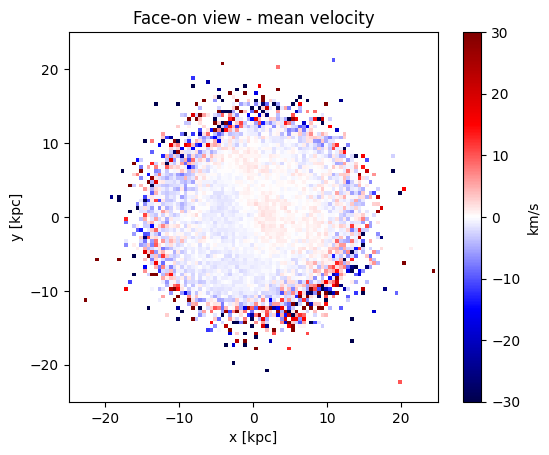

In [62]:
# Zoom out
xlim, ylim = 25, 25
plt_title = 'Face-on view - mean velocity'
cbar_label = 'Vz [km/s]'
bins = 50

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()

#### Face-on - velocity dispersion

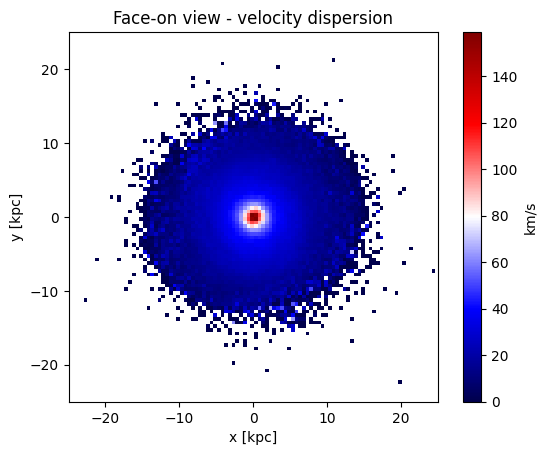

In [63]:
# Zoom out
xlim, ylim = 25, 25
plt_title = 'Face-on view - velocity dispersion'
cbar_label = 'Vz [km/s]'
bins = 50

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()

#### Inclination 60 deg - mean velocity

Rotate 60 degrees clockwise about X axis.
Calculate the binned velocity 2d statistics and plot.

In [64]:
s.rotate_x(-60)

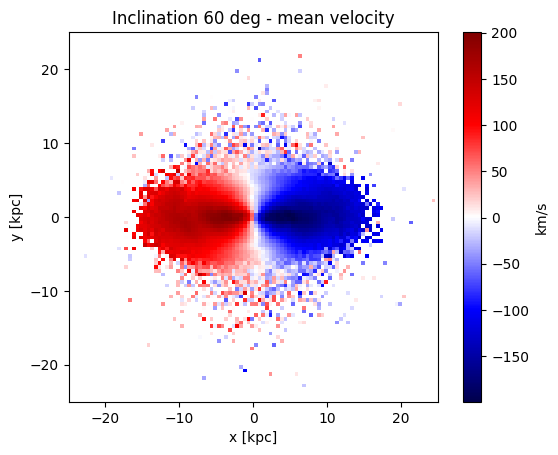

In [65]:
# Zoom out
xlim, ylim = 25, 25
plt_title = 'Inclination 60 deg - mean velocity'
cbar_label = 'Vz tilted [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()


#### Inclination 60 - velocity dispersion

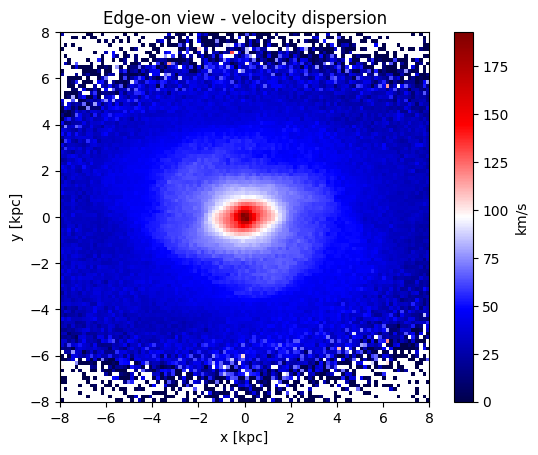

In [66]:
# Zoom in
xlim, ylim = 8, 8
plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'Vz tilted [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()


#### Edge-on - mean velocity

Rotate 90 degrees clockwise about X axis for edge-on view.
Calculate the binned velocity 2d statistics and plot.

In [67]:
s.rotate_x(-30)

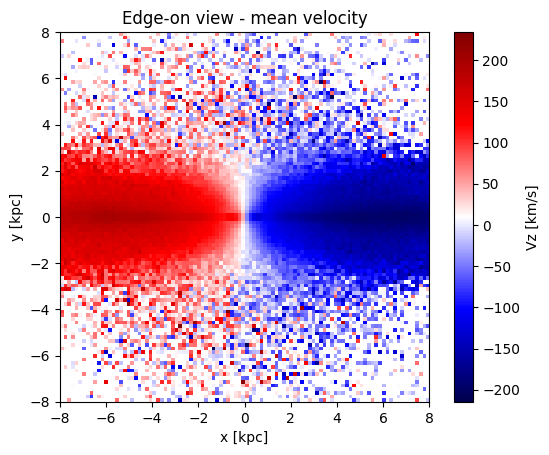

In [80]:
# Zoom in
xlim, ylim = 8, 8
plt_title = 'Edge-on view - mean velocity'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)
plot_image()


#### Edge-on - velocity dispersion

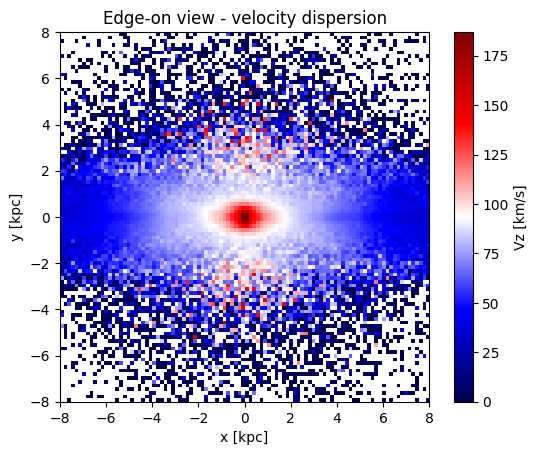

In [79]:
# Zoom in
xlim, ylim = 8, 8
plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'Vz [km/s]'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()


#### Edge-on - h3

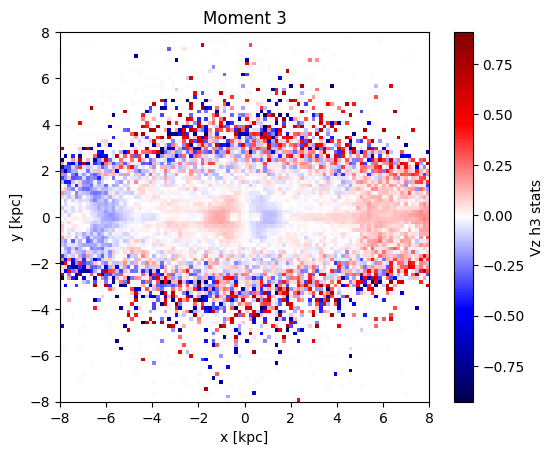

In [77]:
# Zoom in
xlim, ylim = 8, 8
m = 3
plt_title = 'Moment 3'
cbar_label = 'Vz h3 stats'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()

#### Edge-on - h4

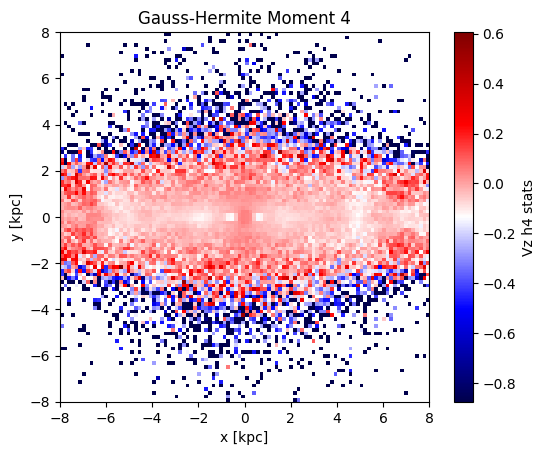

In [76]:
# Zoom in
xlim, ylim = 8, 8
m = 4
plt_title = 'Gauss-Hermite Moment 4'
cbar_label = 'Vz h4 stats'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

plot_image()
